# Notebook to make Figure 3

In [ ]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../utils/plotting.mplstyle')
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../data/different_SNRs/'

### Setup

Load data

In [1]:
# Load in posteriors
posteriors_dict = h5ify.load(data_dir+'posteriors_different_RD_SNRs.h5'),

# Load in the prior
prior_dict = h5ify.load(data_dir+'../real_and_maxL_GW190521/prior.h5')

# Load in the signals' parameters
maxL_params = h5ify.load(data_dir+'../real_and_maxL_GW190521/GW190521_maxL_parameters.h5')
inj_params = h5ify.load(data_dir+'parameters_different_RD_SNRs.h5')

# Load in the signals' strain
injection_strain_dict = h5ify.load(data_dir+'waveforms_different_RD_SNRs.h5')

# Load in JSD vs time
JSD_vs_time = h5ify.load(data_dir+'JSDs_different_RD_SNRs.h5')

# Load in normalized SNR vs time
SNRs_normed_dict = h5ify.load(data_dir+'normalized_SNRs_vs_time_different_RD_SNRs.h5')

Set up plotting aesthetics

In [2]:
# Which SNRs tp plot
SNRs_to_plot = ['SNR 25', 'SNR 30', 'SNR 40', 'SNR 50', 'SNR 75', 'SNR 100']

# Get the prior samples for chi_p
chip_prior_samps = prior_dict['chi_p_m100M']

# True chi-p value
inj_chip = maxL_params['chi_p_m100M']

# Custom colormap 
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("my_cmap", [cp[0], cp2[2], cp[8] , cp2[3], cp[3]])

### Make Figure

Top panel

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/local/simona.miller/ipykernel_2180353/2746864014.py:20: SyntaxWarning: invalid escape sequence '\m'
  inj_line = plt.axvline(inj_chip, ls='--', color='k', label = '$\mathrm{true}~\chi_p$')


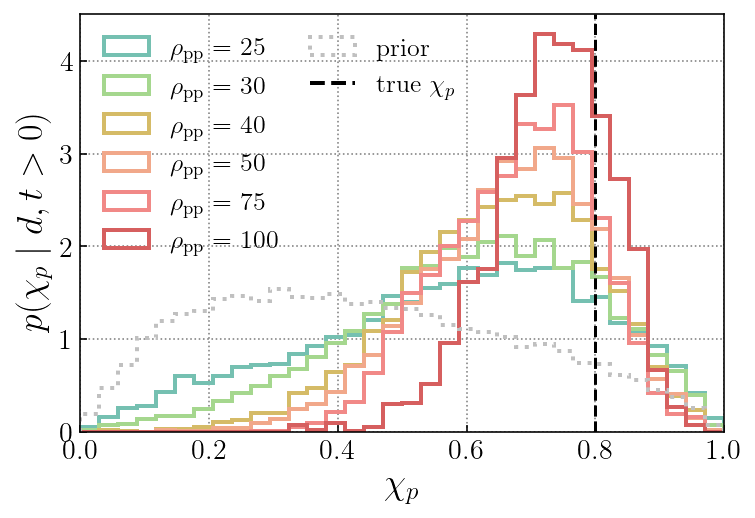

In [3]:
# all the full chi-p posteriors

plt.figure(figsize=(pf.DEFAULT_FIG_WIDTH/2, pf.DEFAULT_FIG_WIDTH/3))

plts = []
for i, k in enumerate(SNRs_to_plot):     
    post = posteriors_dict[0][k]['post 0.0seconds']['chi_p_m100M']

    SNR = k.split('SNR ')[-1]
    x = plt.hist(post, bins=np.linspace(0,1,35), color = cmap((i+1)/6), density=True, histtype='step', lw=2, 
                 label=r'$\rho_{\mathrm{pp}}=$ '+fr'${SNR}$')
    
    plts.append(x) # for custom legend

# plot the prior
prior_plt = plt.hist(chip_prior_samps, bins=np.linspace(0,1,35), color='silver', ls=':', density=True, 
                     histtype='step', lw=2, label=r'$\mathrm{prior}$')

# plot the inejcted value
inj_line = plt.axvline(inj_chip, ls='--', color='k', label = '$\mathrm{true}~\chi_p$')

# make custom legend with different number of items in each column
lgd_kws = dict(loc="upper left", fontsize=13, handlelength=1.75)
legend1 = plt.legend(handles=[x[-1][0] for x in plts], bbox_to_anchor=(0,1), **lgd_kws)
legend2 = plt.legend(handles=[prior_plt[-1][0], inj_line],bbox_to_anchor=(0.32,1), **lgd_kws)
legend2.legend_handles[-1].set_linewidth(2.0)
plt.gca().add_artist(legend1)

#plt.xlim(pf.xlims['chi_p'])
plt.xlabel(r'$\chi_p$')
plt.ylabel(r'$p(\chi_p~|~d, t > 0 )$')
plt.xlim(0,1)
plt.savefig('figure_03a.png', dpi=300, bbox_inches='tight')
plt.show()

Middle and bottom panels

In [4]:
# times for plotting 
times = pf.transform_s_to_M(
    injection_strain_dict['SNR 100']['time_dict']['L1'] - inj_params['SNR 100']['L1_time'], 
    inj_params['SNR 100']['mass_1'] + inj_params['SNR 100']['mass_2'] 
)

# unpack SNRs_normed_dict
snrs_normed = SNRs_normed_dict['SNRs_normed']

/local/simona.miller/ipykernel_2180353/3894595427.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1_upper.set_xticklabels([0,*snrs_normed])


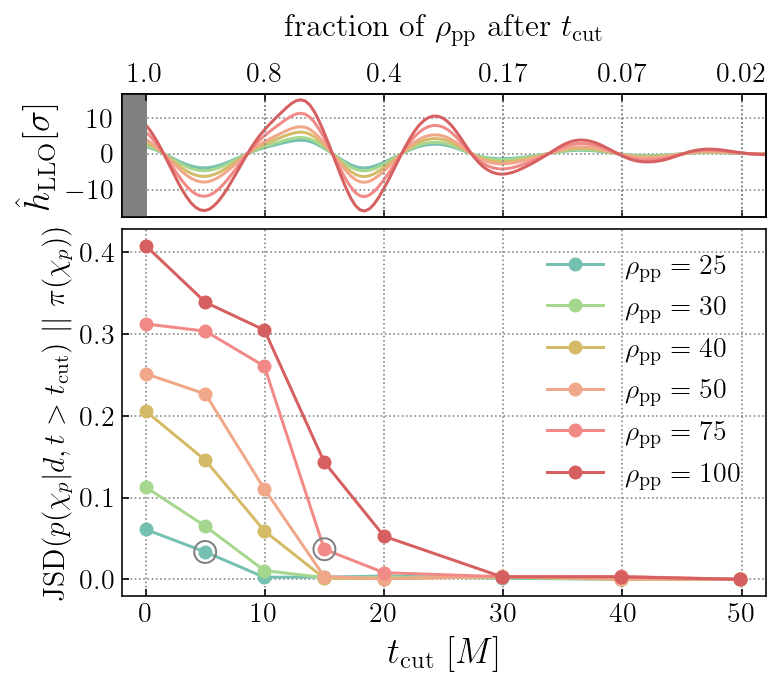

In [5]:
# set up subplots
fig = plt.figure(figsize=(pf.DEFAULT_FIG_WIDTH/2, pf.DEFAULT_FIG_WIDTH/2.5))

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])

## plot waveform vs time
ax1 = plt.subplot(gs[0])
for i, k in enumerate(SNRs_to_plot): 
    
    inj_dict = injection_strain_dict[k]
    strain_wh_L1 = inj_dict['strain_wh']['L1']
    ax1.plot(times, strain_wh_L1, color=cmap((i+1)/6))
ax1.set_xticklabels([])
ax1.set_ylabel(r'$\hat h_{\rm LLO} [\sigma]$')

# shade out region that isn't included
ylim=ax1.get_ylim()
ax1.fill_betweenx(ylim, ax1.get_xlim()[0], x2=0, zorder=3, color='gray')
ax1.set_ylim(ylim)
plt.subplots_adjust(hspace=0.05)


## plot phase vs. JS divergence from prior
ax2 = plt.subplot(gs[1])
i = 0
for k in SNRs_to_plot:
    v = JSD_vs_time[k]
    SNR = k.split('SNR ')[-1]
    ax2.plot(v['tcuts_M'], v['JS_divs'], zorder=3, color=cmap((i+1)/6), marker='o', 
             label=fr'$\rho_\mathrm{{pp}}= {SNR}$')
    i+=1
    
ax2.set_xlabel(r'$t_\mathrm{cut}~[M]$')
ax2.set_ylabel(r'$\mathrm{JSD}(p(\chi_p |d, t>t_\mathrm{cut})~||~ \pi(\chi_p))$', fontsize=15)
ax2.legend()

# circle some relevant points discussed in paper
ax2.scatter([5,15], [JSD_vs_time['SNR 25']['JS_divs'][1], JSD_vs_time['SNR 75']['JS_divs'][3]], 
            marker='o', facecolors='none', edgecolors='gray', s=120, zorder=10)


# upper labels 
ax1_upper = ax1.twiny()

# set xlimits so theyre the same for each plot
for a in [ax1, ax2, ax1_upper]: 
    dx = 2
    a.set_xlim(0-dx,50+dx)
    
ax1_upper.set_xticklabels([0,*snrs_normed])
ax1_upper.set_xlabel(fr'fraction of $\rho_\mathrm{{pp}}$ after $t_\mathrm{{cut}}$', fontsize=16, labelpad=13)
    
plt.savefig('figure_03b.png', dpi=300, bbox_inches='tight')
plt.show()